# Project 1: Pose estimation
## Due Jan. 30th

### Assigned Reading: Szeliski Ch 2.3, Ch. 6.2

### Problem description
One of the most common computer vision tasks, particularly for things like practical robotics, is called *pose estimation*.  *Pose* is simply the computer vision term for the vector
$$
\mathbf{p} = [X_{cam},Y_{cam},Z_{cam},\phi,\theta,\psi],
$$
where the first three elements of the vector are the position of a camera and the last three elements are its yaw, pitch, and roll.  *Pose estimation* is simply determining these values from an image.  

How is this done?  Imagine that we have identified the real-world coordinates $\mathbf{X}_i$ of several features that are easily identified, and fit in one photograph.  We'll call them ground control points (GCPs).
<img src="gcp.jpg">
Using code that we've already developed, we can simulate where these GCPs should project to in the image.  If we already know the correct pose, when we perform this projection, the projection of the GCPs (the steeple of M, for example), should be collocated with that feature in a real image that we took with the camera.  This is a good way of ensuring that our camera model is correct.  

However, usually the pose is not known *a priori*.  Instead, we need to find the pose that reduces the misfit between the projection of the GCPs, and their identified location in the image.  At its core, you can think of this as a least-squares problem: adjust the pose of the model camera such that the squared difference between the projection of the GCP and its location in the image is minimized.  We can write this mathematically as:
$$
\mathbf{p}_{opt} = \mathrm{argmin}_{\mathbf{p}} \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^2 (f(\mathbf{X}_i,\mathbf{p})_j - \mathbf{u}_{ij})^2,
$$
where $n$ is the number of GCPs, and $f(\mathbf{X},\mathbf{p})$ is the projection of real world coordinates $\mathbf{X}$ into camera coordinates (which depends on the pose $\mathbf{p}$, and $\mathbf{u}$ is the pixel coordinates of the equivalent point in the image.  When properly formulated, this minimization problem is straightforward to solve.  The classic method for doing so is the [Levenberg-Marquardt algorithm](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm), which is a generalization of Newton's method and Gradient descent.  

### Software Requirements:
Your assignment is to develop a camera model that has the capability to perform pose estimation.  It should be structured as a Python class with (at least) the following methods:
* A method for performing the projective transform
* A method for performing the transformation from world to generalized camera coordinates
* A method for estimating pose, given ground control points (an excellent python implementation of Levenberg-Marquardt can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html).)

A skeleton for this class might be:

In [72]:
import numpy as np
from scipy.optimize import least_squares


class Camera(object):
    def __init__(self):
        self.p = None                   # Pose
        self.p0 = None
        self.f = None                   # Focal Length in Pixels
        self.c = np.array([None,None])  # 
        self.sensor_size = (None, None)
        
    def projective_transform(self, x):
        """
        This function performs the projective transform on generalized coordinates in the camera reference frame.
        """

        x = np.asarray(x)
        # Assume no intensity column
        x0, y0, z0 = x

        # Camera coors to pixel coors
        u = ((x0 / z0) * self.f) + (self.sensor_size[0] // 2)
        v = ((y0 / z0) * self.f) + (self.sensor_size[1] // 2)

        u_min = np.min(u)
        v_min = np.min(v)

        n = len(u)
        u_list = []
        v_list = []
        for i in range(n):
#             if (u[i] >= u_min and u[i] <= sensor_size[0] and v[i] >= v_min and v[i] <= sensor_size[1]):
            u_list.append(u[i])
            v_list.append(v[i])

        u = np.asarray(u_list)
        v = np.asarray(v_list)

        return np.vstack((u, v))

    @staticmethod
    def make_cam_mtx(fi, theta, psi, translation_vec):

        translation_mtx = np.array([[1, 0, 0, -translation_vec[0]],
                                    [0, 1, 0, -translation_vec[1]],
                                    [0, 0, 1, -translation_vec[2]],
                                    [0, 0, 0, 1]])

        # Apply yaw. It represents rotation around camera's z axis
        cos_fi = np.cos(fi)
        sin_fi = np.sin(fi)
        R_yaw = np.array([[cos_fi, -sin_fi, 0, 0],
                          [sin_fi, cos_fi, 0, 0],
                          [0, 0, 1, 0]])

        # Apply pitch. Represents rotation around camera's x axis
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        R_pitch = np.array([[1, 0, 0],
                            [0, cos_theta, sin_theta],
                            [0, -sin_theta, cos_theta]])

        # Apply roll. Represents rotation around camera's y axis
        cos_psi = np.cos(psi)
        sin_psi = np.sin(psi)
        R_roll = np.array([[cos_psi, 0, -sin_psi],
                           [0, 1, 0],
                           [sin_psi, 0, cos_psi]])

        R_ax_swp = np.array([[1, 0, 0],
                             [0, 0, -1],
                             [0, 1, 0]])

        return R_ax_swp @ R_roll @ R_pitch @ R_yaw @ translation_mtx

    def rotational_transform(self, X):
        """
        This function performs the translation and rotation from world coordinates into generalized camera coordinates.
        """

        # Unpack pose? could do something different here.
        X_cam, Y_cam, Z_cam, azimuth_cam_deg, pitch_cam_deg, roll_cam_deg = self.p

        # Make X a set of homogeneous coors
        X = np.vstack((X, np.ones(X.shape[1])))

        # Convert degrees to radians
        azimuth_cam_rad = np.deg2rad(azimuth_cam_deg)
        pitch_cam_rad = np.deg2rad(pitch_cam_deg)
        roll_cam_rad = np.deg2rad(roll_cam_deg)

        translation_vec = [X_cam, Y_cam, Z_cam]
        C = self.make_cam_mtx(azimuth_cam_rad, pitch_cam_rad, roll_cam_rad, translation_vec)

        return C @ X
    
    def estimate_pose(self, X_gcp, u_gcp):
        """
        This function adjusts the pose vector such that the difference between the observed pixel coordinates u_gcp
        and the projected pixels coordinates of X_gcp is minimized.
        """
        
        self.p = self.p0.copy()
        
        def residuals(p, X_gcp, u_gcp):
            self.p = p.copy()
            xuv = self.ene_to_camera(X_gcp)
            return xuv.flatten() - u_gcp.flatten()
            
        res = least_squares(residuals, self.p, args=(X_gcp, u_gcp))
        self.p = res.x

    # f
    def ene_to_camera(self, X):
        return self.projective_transform(self.rotational_transform(X))


### Testing Requirements
You should test this code on real world imagery of your own making.  Go out into the world and take a photograph of a scene in which you will be able to identify real world coordinates.  As an example (which you are free to emulate), I took a photograph of main hall from the oval (see above).  In the background was the M, along with a few other things.  I selected several prominent features in my image, recorded their image coordinates, then used google earth (with coordinates set to UTM mode) to determine their location in world coordinates:

| u  | v  | Easting | Northing | Elevation | Description    |
|----|----|---------|----------|-----------|----------------|
|1984|1053|272558.68|5193938.07|1015       |Main hall spire |
|884 |1854|272572.34|5193981.03|982        |Large spruce    |
|1202|1087|273171.31|5193846.77|1182       |Bottom of left tine of M|
|385 |1190|273183.35|5194045.24|1137       |Large rock outcrop on Sentinel|
|2350|1442|272556.74|5193922.02|998        |Southernmost window apex on main hall|

I saved this table as a txt file, which I read and then use in my estimate_pose function.  

### Additional notes
* The pose vector has six elements.  Each ground control point has two observations ($u$ and $v$).  How many points are needed to fully constrain the minimization problem?  (note that more observations is always better, but there is a minimum for the problem to be well posed)

* You will need to determine the focal length from your camera.  To do this you will need to read the image's [Exif file](https://en.wikipedia.org/wiki/Exif).  Many image viewers (eye of gnome, for example) will do this automatically.  Look under Properties.  Alternatively, the Linux command line tool imagemagick can be used:

In [5]:
%%bash
identify -verbose img_oval.JPG | grep "exif:" | grep Dimension
identify -verbose img_oval.JPG | grep "exif:" | grep 35mm

    exif:PixelXDimension: 4032
    exif:PixelYDimension: 3024
    exif:FocalLengthIn35mmFilm: 29


phone cameras typically report focal length in 35mm equivalent.  Confusingly, to get focal length in pixels, divide this number by *36*, then multiply by the width of the image in pixels.  Hence, for this image, the focal length is 

In [3]:
f_length_35 = 29
img_width = 3024
img_height = 4032

f_length = f_length_35/36*img_width
print(f_length)
sensor_size = (img_width, img_height)

2436.0


In [1]:
def read_gcp(fname):
    u = []
    v = []
    east = []
    north = []
    ele = []
    desc = []
    with open(fname) as fd:
        for i, line in enumerate(fd):
            if i < 2:
                # skip header
                continue
            vals = line.split("|")[1:-1]
            u.append(int(vals[0]))
            v.append(int(vals[1]))
            east.append(float(vals[2]))
            north.append(float(vals[3]))
            ele.append(float(vals[4]))
            desc.append(vals[5])
    uv = np.vstack((u, v))
    ene = np.vstack((east, north, ele))
    return uv, ene

In [108]:
from scipy import ndimage
import matplotlib.pyplot as plt

img_raw = plt.imread("img_oval.JPG")
img_base = ndimage.rotate(img_raw, -90)

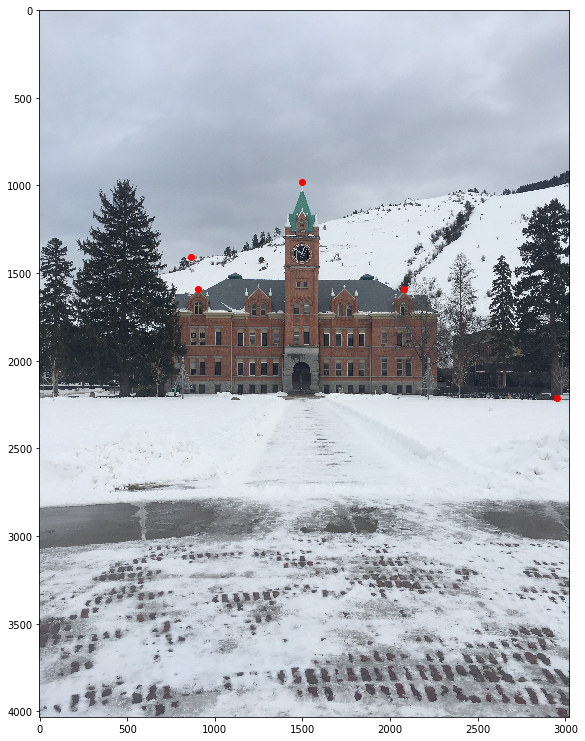

In [118]:
import matplotlib.pyplot as plt

uv, ene = read_gcp("point_table.txt")
u, v = uv
plt.figure(figsize=(10, 13))
plt.imshow(img_base)
plt.scatter(u, v, color='r')
plt.show()

In [119]:
sensor_size = (img_width, img_height)
cam = Camera()
cam.f = f_length
cam.sensor_size = sensor_size

In [120]:
cam.p0 = np.array([272461, 5193942, 982, 90, 0, 0])
cam.estimate_pose(ene, uv)
print(cam.p)

[2.72509544e+05 5.19390769e+06 9.82541908e+02 6.52690271e+01 4.60539127e+00 4.26134597e+00]


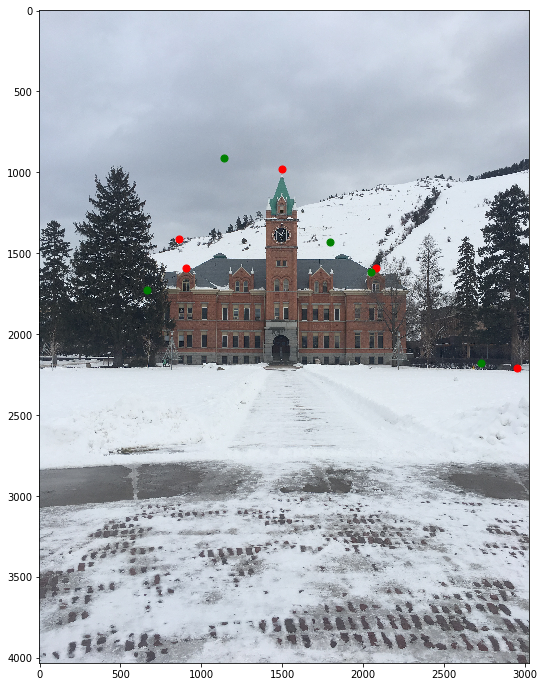

In [121]:
puv = cam.ene_to_camera(ene)
plt.figure(figsize=(12, 12))
plt.imshow(img_base)
plt.scatter(u, v, color='r', s=50)
plt.scatter(puv[0], puv[1], color='g', s=50)
plt.show()